# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import numpy as np
import cv2
import pickle
import tqdm

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(y_train) + 1  # zero-based indexing

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

[  210.  2220.  2250.  1410.  1980.  1860.   420.  1440.  1410.  1470.
  2010.  1320.  2100.  2160.   780.   630.   420.  1110.  1200.   210.
   360.   330.   390.   510.   270.  1500.   600.   240.   540.   270.
   450.   780.   240.   689.   420.  1200.   390.   210.  2070.   300.
   360.   240.   240.]
Mean: 911.84, Dev: 687.72


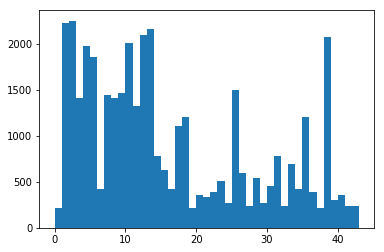

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# class distribution: we can see how many imbalanced classes are in the train dataset
class_distribution, _, patches = plt.hist(y_train, bins=np.arange(0,n_classes+1))

print(class_distribution)
# give the mean of classes
balancing_mean = np.mean(class_distribution)
std_dev = np.std(class_distribution)

print("Mean: {:.2f}, Dev: {:.2f}".format(balancing_mean, std_dev))

(array([ 210.,  210.,  210.,  210.,  210.,  210.,  210.,  210.,  210.,
         210.,  210.,  210.,  210.,  210.,  210.,  210.,  210.,  210.,
         210.,  210.,  210.,  210.,  210.,  210.,  210.,  210.,  210.,
         210.,  210.,  210.,  210.,  210.,  210.,  210.,  210.,  210.,
         210.,  210.,  210.,  210.,  210.,  210.,  210.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 43 Patch objects>)

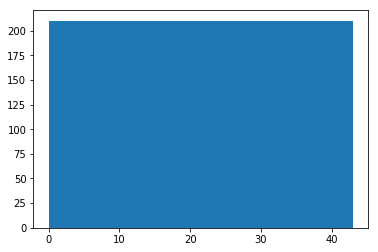

In [4]:
# under sampling (class balancing)
from imblearn.under_sampling import NearMiss

undersampler = NearMiss(return_indices=True)
_,_, indexes = undersampler.fit_sample(np.random.randn(len(X_train), 1), y_train)

X_under = X_train[indexes]
y_under = y_train[indexes]
plt.hist(y_under, bins=np.arange(0,n_classes+1))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def adaptive_histogram_equalization(image):
    adaptive_histogram_equalizer = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(4,4))
    return adaptive_histogram_equalizer.apply(image)


def image_adjust(image):
    return exposure.rescale_intensity(image)


def histogram_equalization(image):
    return cv2.equalizeHist(image)


def contrast_normalization(image):
    blurred = cv2.GaussianBlur(image, (3,3), 0)
    return cv2.Laplacian(blurred, cv2.CV_8U, 3)


def flatten(image):
    return image.ravel()


def preprocess(train_input):
    preprocessed_images = []

    for image in train_input:
        preprocessed_image = grayscale(image)
        preprocessed_image = histogram_equalization(preprocessed_image)
        preprocessed_image = flatten(preprocessed_image)
        preprocessed_images.append(preprocessed_image)

    return preprocessed_images

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
The preprocessing pipeline is inspired by the one proposed on Multi-Column Deep Neural Network for Traffic Sign Classification by Dan Cireşan et alter. However, it turns out that applying all the four Image Adjustment, Histogram Equalization, Adaptive Histogram Equalization, Contrast Normalization techniques did not result on better performance on the validation set.

The grayscale conversion is inspired by Sermanet&Lecun referenced paper.

/home/linuxpotter/.virtualenvs/selfd/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: This function is deprecated. Please call randint(-2, 2 + 1) instead
/home/linuxpotter/.virtualenvs/selfd/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(-15, 15 + 1) instead
Augmenting: 100%|██████████| 9030/9030 [00:02<00:00, 3485.13it/s]


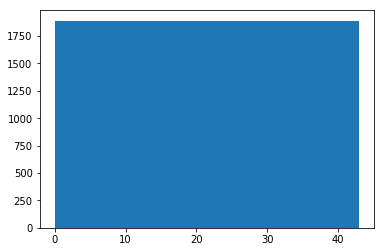

In [6]:
TRAIN_FILE = 'data/train.p'

TRANSLATION_RANGE = (-2, 2)
SCALE_RANGE = (0.9, 1.1)
ROTATION_RANGE = (-15, 15)

DEFAULT_TRANSFORMS = [[-2, 0], [0, -2], [2, 0], [0, 2]]
DEFAULT_SCALES = list(SCALE_RANGE)
DEFAULT_ANGLES = list(ROTATION_RANGE)

SAMPLES = 4
STOCHASTIC_TRANSFORMS = np.split(np.random.random_integers(low=TRANSLATION_RANGE[0], high=TRANSLATION_RANGE[1], size=SAMPLES), 2)
STOCHASTIC_SCALES = np.random.uniform(low=SCALE_RANGE[0], high=SCALE_RANGE[1], size=SAMPLES)
STOCHASTIC_ANGLES = np.random.random_integers(low=ROTATION_RANGE[0], high=ROTATION_RANGE[1], size=SAMPLES)


def translate(image, transforms=DEFAULT_TRANSFORMS):
    translated = []

    for transform in transforms:
        m = np.float32([[1, 0, transform[0]], [0, 1, transform[1]]])
        translated.append(cv2.warpAffine(image, m, dsize=(image.shape[0], image.shape[1])))

    return translated


def scale(image, scales=DEFAULT_SCALES):
    scaled = []

    for random_scale in scales:
        scaled_image = cv2.resize(image, None, fx=random_scale, fy=random_scale)
        scaled_image = cv2.resize(scaled_image, dsize=(image.shape[0], image.shape[1]))
        scaled.append(scaled_image)
    return scaled


def rotate(image, angles=DEFAULT_ANGLES):
    rotated = []

    for angle in angles:
        center = tuple(np.array(image.shape[:2]) / 2)
        R = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(image, R, image.shape[:2], flags=cv2.INTER_CUBIC)
        rotated.append(rotated_image)

    return rotated


def deterministic(train_input, train_labels):
    augmented = { 'features': [], 'labels': [] }

    for image, label in tqdm.tqdm(zip(train_input, train_labels), desc='Augmenting', total=len(train_input)):
        augmented['features'].append(image)
        augmented['labels'].append(label)
        for _image in translate(image):
            augmented['features'].append(_image)
            augmented['labels'].append(label)
        for _image in scale(image):
            augmented['features'].append(_image)
            augmented['labels'].append(label)
        for _image in rotate(image):
            augmented['features'].append(_image)
            augmented['labels'].append(label)

    return augmented


def stochastic(train_input, train_label):
    augmented = []

    for image, label in zip(train_input, train_label):
        augmented.append(translate(image, transforms=STOCHASTIC_TRANSFORMS))
        augmented.append(scale(image, scales=STOCHASTIC_SCALES))
        augmented.append(rotate(image, angles=STOCHASTIC_ANGLES))

    return augmented


def augment(file='data/augmented_train.pickle'):
    augmented = deterministic(X_under, y_under)

    class_distribution, _, patches = plt.hist(augmented['labels'], bins=np.arange(0,n_classes + 1))
    
    pickle.dump(augmented, open(file, 'wb+'))
    
augment()

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Additional data was generated using the techniques proposed in Sermanet&Lecun and Ciresan et. alt. Deterministic perturbations on scale, translation and rotation where carried on each original image. The complete agumented dataset was store on disk. The complete augmented dataset was divide into 80% training and 20% validation.


In [7]:
import tensorflow as tf

FIRST_STAGE = {
    'depth': 108,
    'filter_size': 5,
    'padding': 'SAME',
    'stride': (1, 1, 1, 1)
}
SECOND_STAGE = {
    'depth': 108,
    'filter_size': 5,
    'padding': 'SAME',
    'stride': (1, 1, 1, 1)
}
FULL_CONNECTION = {
    'hidden_units': 100,
}
FLATTEN_LAYER_SIZE = 108 * 8 * 8


def weights(shape, stddev=0.01):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=stddev, mean=0))


def bias(shape, value=0.0):
    return tf.Variable(tf.constant(value=value, shape=shape))


def conv2d(input, filters_size, num_filters, input_depth, padding='VALID', strides=[1, 1, 1, 1]):

    W = weights([filters_size, filters_size, input_depth, num_filters])  # filters
    b = bias([num_filters])  # bias

    return tf.nn.conv2d(input, W, padding=padding, strides=strides) + b


def relu(layer):
    return tf.nn.relu(layer)


def max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME'):
    return tf.nn.max_pool(layer, ksize=ksize, strides=strides, padding=padding)


def fully_connected(x, num_inputs, num_outputs):
    W = weights([num_inputs, num_outputs])
    b = bias([num_outputs])
    return tf.matmul(x, W) + b

def stack(network_input, network_input_depth, output_size):

    first_stage = conv2d(network_input, FIRST_STAGE['filter_size'], FIRST_STAGE['depth'],
                                     network_input_depth, FIRST_STAGE['padding'], FIRST_STAGE['stride'])
    first_stage = max_pool(first_stage)
    first_stage = relu(first_stage)

    second_stage = conv2d(first_stage, SECOND_STAGE['filter_size'], SECOND_STAGE['depth'],
                                      FIRST_STAGE['depth'], SECOND_STAGE['padding'], SECOND_STAGE['stride'])
    second_stage = max_pool(second_stage)
    second_stage = relu(second_stage)

    skip_layer = max_pool(first_stage)
    skip_layer = tf.add(second_stage, skip_layer)
    skip_layer = tf.reshape(skip_layer, [-1, FLATTEN_LAYER_SIZE])

    fc = fully_connected(skip_layer, FLATTEN_LAYER_SIZE, FULL_CONNECTION['hidden_units'])
    classification = fully_connected(fc, FULL_CONNECTION['hidden_units'], output_size)

    return classification

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The sequential model proposed tries to resemble the EBLearn 2-layer ConvNet ms proposed on Sermanet et alt. Two convolution stacks (convolutional layer, max pool, activation with a ReLU). The details of the configuration are available on the cell above on the FIRST_STAGE, SECOND_STAGE, FULL_CONNECTION configuration variables. One particularity of this architecture (named multi-staged on the papers) is the use of a Merge layer (implemented using tf.add).

In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.
BATCH_SIZE = 32
EPOCHS = 20
PRE_TRAINED_FILE = 'sermanet_lecun'
CHECKPOINT_DIR = '/'
MAX_EPOCHS_NO_IMPROVE = 5


def optimize(stack, encoded_y, learning_rate=1e-4):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(stack, encoded_y)
    loss = tf.reduce_mean(cross_entropy)
    return tf.train.AdamOptimizer(learning_rate).minimize(loss)


def evaluate(stack, encoded_y):
    y_prediction = tf.nn.softmax(stack)
    prediction_match = tf.equal(tf.argmax(y_prediction, dimension=1), tf.argmax(encoded_y, dimension=1))
    return prediction_match  # tf.reduce_mean(tf.cast(prediction_match, tf.float32))


def compose(prediction_size):
    x = tf.placeholder(tf.float32, [None, 1024])
    x_4d = tf.reshape(x, [-1, 32, 32, 1])

    y = tf.placeholder(tf.int32, [None])
    classifier = tf.one_hot(y, prediction_size)

    net = stack(network_input=x_4d, network_input_depth=1, output_size=prediction_size)

    optimizer = optimize(net, classifier)
    evaluator = evaluate(stack=net, encoded_y=classifier)

    return optimizer, evaluator, x, y


def train(train_input, train_output, validation_input, validation_output, prediction_size):
    optimizer, evaluator, x, y = compose(prediction_size)

    saver = tf.train.Saver()

    best_validation_accuracy = 0.
    last_improving_epoch = 0

    with tf.Session() as session:
        checkpoint_state = tf.train.get_checkpoint_state(CHECKPOINT_DIR)
        if checkpoint_state and checkpoint_state.model_checkpoint_path:
            saver.restore(session, PRE_TRAINED_FILE)
        else:
            session.run(tf.global_variables_initializer())

        input_size = len(train_input)
        validation_size = len(validation_input)

        for epoch in range(EPOCHS):
            for batch in tqdm.tqdm(range(0, input_size, BATCH_SIZE), desc='Mini Batch Training'):
                input_batch, output_batch = preprocess(train_input[batch:batch+BATCH_SIZE]), \
                                            train_output[batch:batch+BATCH_SIZE]
                session.run(optimizer, feed_dict={x: input_batch, y: output_batch})

            predictions = []
            for batch in tqdm.tqdm(range(0, validation_size, BATCH_SIZE), desc='Mini Batch Validation'):
                sample_input, sample_output = preprocess(validation_input[batch:batch + BATCH_SIZE]), \
                                              validation_output[batch:batch + BATCH_SIZE]
                predictions.extend(session.run(evaluator, feed_dict={x: sample_input, y: sample_output}))
            validation_accuracy = np.mean(np.array(predictions).astype(np.float32))
            
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                saver.save(sess=session, save_path=PRE_TRAINED_FILE)
                last_improving_epoch = epoch

            print("Training Epoch: {}, Accuracy: {:.4f}\n".format(epoch, validation_accuracy))
            
            # early stopping if no improvement for two epochs
            if last_improving_epoch - epoch > MAX_EPOCHS_NO_IMPROVE:
                break

        session.close()

In [9]:
from sklearn.model_selection import train_test_split
TRAIN_FILE = 'data/augmented_train.pickle'
VALIDATION_TEST_PERCENTAGE = 0.10

def load_train_data():
    with open(TRAIN_FILE, mode='rb') as f:
        train = pickle.load(f)

    return train_test_split(train['features'], train['labels'], test_size=VALIDATION_TEST_PERCENTAGE)

train_input, validation_input, train_output, validation_output = load_train_data()
train(train_input, train_output, validation_input, validation_output, 43)

Mini Batch Training:   0%|          | 3/2286 [00:00<01:39, 23.04it/s]

Training Epoch: 0, Accuracy: 0.9402



Mini Batch Training:   0%|          | 3/2286 [00:00<01:43, 22.16it/s]

Training Epoch: 1, Accuracy: 0.9722



Mini Batch Training:   0%|          | 3/2286 [00:00<01:36, 23.62it/s]

Training Epoch: 2, Accuracy: 0.9791



Mini Batch Training:   0%|          | 3/2286 [00:00<01:36, 23.59it/s]

Training Epoch: 3, Accuracy: 0.9830



Mini Batch Training:   0%|          | 3/2286 [00:00<01:39, 22.84it/s]

Training Epoch: 4, Accuracy: 0.9811



Mini Batch Training:   0%|          | 3/2286 [00:00<01:47, 21.32it/s]

Training Epoch: 5, Accuracy: 0.9856



Mini Batch Training:   0%|          | 2/2286 [00:00<01:55, 19.71it/s]

Training Epoch: 6, Accuracy: 0.9838



Mini Batch Training:   0%|          | 3/2286 [00:00<01:41, 22.50it/s]

Training Epoch: 7, Accuracy: 0.9893



Mini Batch Training:   0%|          | 3/2286 [00:00<01:36, 23.60it/s]

Training Epoch: 8, Accuracy: 0.9831



Mini Batch Training:   0%|          | 3/2286 [00:00<01:41, 22.47it/s]

Training Epoch: 9, Accuracy: 0.9874



Mini Batch Training:   0%|          | 3/2286 [00:00<01:40, 22.76it/s]

Training Epoch: 10, Accuracy: 0.9899



Mini Batch Training:   0%|          | 3/2286 [00:00<01:38, 23.08it/s]

Training Epoch: 11, Accuracy: 0.9858



Mini Batch Training:   0%|          | 3/2286 [00:00<01:37, 23.32it/s]

Training Epoch: 12, Accuracy: 0.9895



Mini Batch Training:   0%|          | 3/2286 [00:00<01:40, 22.71it/s]

Training Epoch: 13, Accuracy: 0.9926



Mini Batch Training:   0%|          | 3/2286 [00:00<01:37, 23.39it/s]

Training Epoch: 14, Accuracy: 0.9890



Mini Batch Training:   0%|          | 3/2286 [00:00<01:39, 22.84it/s]

Training Epoch: 15, Accuracy: 0.9892



Mini Batch Training:   0%|          | 3/2286 [00:00<01:39, 22.96it/s]

Training Epoch: 16, Accuracy: 0.9890



Mini Batch Training:   0%|          | 2/2286 [00:00<01:55, 19.72it/s]

Training Epoch: 17, Accuracy: 0.9911



Mini Batch Training:   0%|          | 3/2286 [00:00<01:38, 23.19it/s]

Training Epoch: 18, Accuracy: 0.9895



Mini Batch Validation: 100%|██████████| 254/254 [00:03<00:00, 75.11it/s]

Training Epoch: 19, Accuracy: 0.9827



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The training was performed using Adam optimizer with initial learning rate of 1e-4 and with a size of 32 for each batch by 100 epochs (number may change because of restarting the notebook loads the pre-trained model). An early stopping is performed if there is no improvement on the validation accuracy for 5 epochs. Keeping track of the validation accuracy, the most accurate model is store on disk.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I reviewed several papers focused on the traffic sign classification problem, including: 
 
- Multi-Column Deep Neural Network for Traffic Sign Classification, by Dan Cireşan et alt.

- A Practical and Highly Optimized Convolutional Neural Network for Classifying Traffic Signs in Real-Time
by Hamed Habibi Aghdam et alt.

- Traffic Sign Recognition with Multi-Scale Convolutional Networks by Pierre Sermanet et alt.

- Traffic Sign Recognition Using Extreme Learning Classifier with Deep Convolutional Features by Yujun Zeng et alt.

The final solution was a combination of several ideas and a some hours of experimentation. The architecture selected depicted on Sermanet et. alt. posed a significant challenge given that it was not completely specified. Probably the best solution of all researched is the one by Habibi et alt. but I had not enough computational resources to execute it. I made some efforts to compare each implementations which can be found at: https://github.com/takeitallsource/TrafficSign-ConvNet-Evaluation

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.